<a href="https://colab.research.google.com/github/DaniilSysoev/opisis_sem_9/blob/main/%D0%9E%D0%BF%D0%B8%D1%81%D0%B8%D1%81_%D1%81%D0%B5%D0%BC_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Возбуждение линии передачи гармоническим сигналом. Особенности распространения сигналов в линии передачи. Распределение напряжений вдоль ЛП. Влияние условий согласования на распространение сигнала. Возбуждение ЛП вблизи границ полосы пропускания.</h1>

<h2>Получить сигналы и их спектры на входе и выходе линии передачи при возбуждении её гармоническим и плавно нарастающим сигналом.
Рассмотреть вопрос распределения напряжения вдоль ЛП. Высчитать, как влияет условие согласования на распространение сигнала.</h2>

<h3>Добавим необходимые для рассчета библиотеки</h3>

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

<h3>Добавим функции для расчета</h3>

In [2]:
#Производная гармонического сигнала
def d_harm_signal1(t):
    return 2.0*pi*fc*sin(2.0*pi*fc*t)

#Производная гармонического сигнала с плавным нарастанием
def d_harm_signal2(t):
    coef = 1 if t > 1 else t
    return 2.0*pi*fc*coef*sin(2.0*pi*fc*t)

#Перевод частоты в циклическую
def f2w(f):
    return 2.0*pi*f

<h3>Введем необходимые данные</h3>

In [3]:
global fc, Tc, fl, fh

fc = float(input('Частота сигнала возбуждения ЛП '))
Tc = float(input('Временной интервал '))
fl = float(input('Нижняя граничная частота ЛП '))
fh = float(input('Верхняя граничная частота ЛП '))
f0 = (fl + fh) * 0.5
Z0 = float(input('Характеристическое сопротивление одного звена ЛП на частоте '+str(f0)+' '))
Nc = int(input('Число ячеек в ЛП '))

Частота сигнала возбуждения ЛП 10
Временной интервал 20
Нижняя граничная частота ЛП 5
Верхняя граничная частота ЛП 15
Характеристическое сопротивление одного звена ЛП на частоте 10.0 50
Число ячеек в ЛП 10


<h3>Рассчитаем входные и выходные параметры для первого сигнала</h3>

Параметры отдельной ячейки ЛП:
C1 =  0.000153
C2 =  0.001223
L =  0.828269
dpp =  20
  0.000   0.000   0.000 
  1.000  -0.462   0.265 
  2.000  -0.462   0.338 
  3.000  -0.462   0.338 
  4.000  -0.462   0.338 
  5.000  -0.462   0.338 
  6.000  -0.462   0.338 
  7.000  -0.462   0.338 
  8.000  -0.462   0.338 
  9.000  -0.462   0.338 
 10.000  -0.462   0.338 
 11.000  -0.462   0.338 
 12.000  -0.462   0.338 
 13.000  -0.462   0.338 
 14.000  -0.462   0.338 
 15.000  -0.462   0.338 
 16.000  -0.462   0.338 
 17.000  -0.462   0.338 
 18.000  -0.462   0.338 
 19.000  -0.462   0.338 


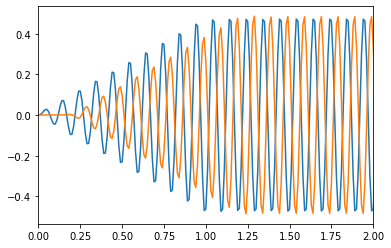

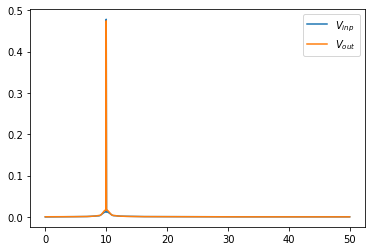

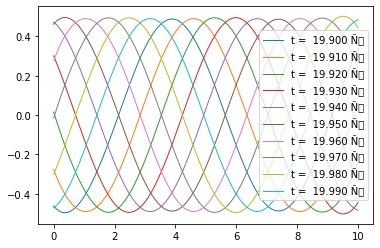

In [11]:
L = (sqrt(Z0**2*f2w(f0)**2*(2*f2w(fh)**2-f2w(fl)**2-f2w(f0)**2)/
    ((f2w(fh)**2-f2w(fl)**2)**2*(f2w(f0)**2-f2w(fl)**2))))
C1 = 1.0 / L / (f2w(fh)**2 - f2w(fl)**2)
C2 = 1.0 / (f2w(fl)**2 * L)
G = 0
print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))

npp = 10            #Количество точек на период гармонического сигнала
dt = 1/(fc*npp)     #Шаг по времени
num = int(Tc / dt)  #Количество временных отсчетов

freq = np.linspace(0.8*fl, fh*1.2, num)

#Задание производной сигнала возбуждения ЛП
d_signal = d_harm_signal2

A0 = 1 #Амплитуда сигнала слева
AN = 0 #Амплитуда сигнала справа
K0 = KN = 1 #Коэффициенты при нагрузочных сопротивлениях

#Количество итераций для решения уравнений возбуждения
dpp = 20
print('dpp = {0: d}'.format(dpp))

aU = [0] * Nc     #Массив напряжений на емкости C2
dU = [0] * Nc     #Массив производных напряжений на емкости C2
aV = [0] * (Nc+1) #Массив напряжений на емкости C1
dV = [0] * (Nc+1) #Массив производных напряжений на емкости C1

Vinp = [0] * num  #Массив входных напряжений
Vout = [0] * num  #Массив выходных напряжений
time = [0] * num  #Массив временных отсчетов
Vs = [0] * npp    #Массив напряжений на C1 вдоль ЛП на одном периоде сигнала

for i in range(npp): Vs[i] = [0] * (Nc+1)

#Решение уравнений возбуждения ЛП
for it in range(num):        
    time[it] = dt * it
    for i in range(dpp):
        dV[0] += (1.0/(L*C1)*(aV[1]-aV[0]+aU[0])+1.0/(Z0*K0*C1)*(A0*d_signal(time[it])-dV[0]))*dt/dpp
        for ic in range (Nc):
            dU[ic] += (1.0/(L*C2)*(aV[ic]-aV[ic+1]-aU[ic])-G/C2*dU[ic])*dt/dpp
            if ic == 0: continue
            dV[ic] += (0.5/(L*C1)*(aV[ic-1]-2.0*aV[ic]+aV[ic+1]+aU[ic]-aU[ic-1]))*dt/dpp
        dV[Nc] += (1.0/(L*C1)*(aV[Nc-1]-aV[Nc]-aU[Nc-1])+1.0/(Z0*KN*C1)*(AN*d_signal(time[it])-dV[Nc]))*dt/dpp
        for ic in range(Nc):
            aV[ic] += dV[ic]*dt/dpp
            aU[ic] += dU[ic]*dt/dpp
        aV[Nc] += dV[Nc]*dt/dpp
    if num-it <= npp:
        for ic in range(Nc+1):
            Vs[it-(num-npp)][ic] = aV[ic]
    Vinp[it] = aV[0]
    Vout[it] = aV[Nc]
    if it % 100 == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp[it], Vout[it]))

#Расчет спектра входного и выходного сигалов
spectr_inp = np.fft.fft(Vinp)
spectr_out = np.fft.fft(Vout)
fft_freq = np.fft.fftfreq(num, Tc/num)
plt.axis(xmin=0, xmax=2)
plt.plot(time, Vinp, time, Vout)
plt.show()

sp_inp = np.hypot(spectr_inp.real, spectr_inp.imag)/num*2
sp_out = np.hypot(spectr_out.real, spectr_out.imag)/num*2
plt.plot(fft_freq[0:num//2], sp_inp[0:num//2], label='$V_{inp}$')
plt.plot(fft_freq[0:num//2], sp_out[0:num//2], label='$V_{out}$')
plt.legend(loc='best')
plt.show()

cells = np.linspace(0, Nc, Nc+1)
z_spl = np.linspace(0, Nc, (Nc+1)*10)
for i in range(npp):
    spl = make_interp_spline(cells, Vs[i], k=3)
    plt.plot(z_spl, spl(z_spl), label="t = {0: .3f} Ñ".format(time[num-npp+i]), lw=1)
plt.legend(loc='best')
plt.show()



<h3>Рассчитаем второй сигнал для AN=1</h3>

Параметры отдельной ячейки ЛП:
C1 =  0.000153
C2 =  0.001223
L =  0.828269
dpp =  20
  0.000   0.000   0.000 
  1.000  -0.197  -0.197 
  2.000  -0.124  -0.124 
  3.000  -0.124  -0.124 
  4.000  -0.124  -0.124 
  5.000  -0.124  -0.124 
  6.000  -0.124  -0.124 
  7.000  -0.124  -0.124 
  8.000  -0.124  -0.124 
  9.000  -0.124  -0.124 
 10.000  -0.124  -0.124 
 11.000  -0.124  -0.124 
 12.000  -0.124  -0.124 
 13.000  -0.124  -0.124 
 14.000  -0.124  -0.124 
 15.000  -0.124  -0.124 
 16.000  -0.124  -0.124 
 17.000  -0.124  -0.124 
 18.000  -0.124  -0.124 
 19.000  -0.124  -0.124 


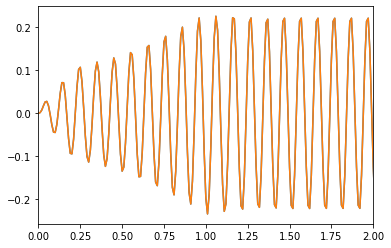

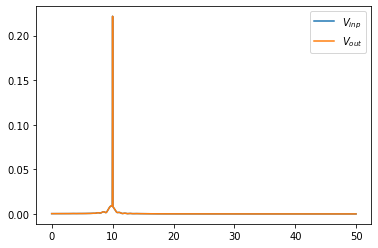

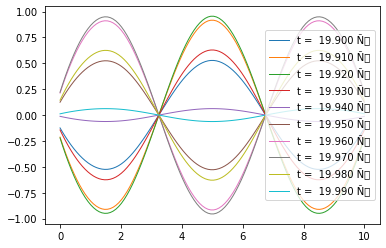

In [12]:
L = (sqrt(Z0**2*f2w(f0)**2*(2*f2w(fh)**2-f2w(fl)**2-f2w(f0)**2)/
    ((f2w(fh)**2-f2w(fl)**2)**2*(f2w(f0)**2-f2w(fl)**2))))
C1 = 1.0 / L / (f2w(fh)**2 - f2w(fl)**2)
C2 = 1.0 / (f2w(fl)**2 * L)
G = 0
print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))

npp = 10            #Количество точек на период гармонического сигнала
dt = 1/(fc*npp)     #Шаг по времени
num = int(Tc / dt)  #Количество временных отсчетов

freq = np.linspace(0.8*fl, fh*1.2, num)

#Задание производной сигнала возбуждения ЛП
d_signal = d_harm_signal2

A0 = 1 #Амплитуда сигнала слева
AN = 1 #Амплитуда сигнала справа
K0 = KN = 1 #Коэффициенты при нагрузочных сопротивлениях

#Количество итераций для решения уравнений возбуждения
dpp = 20
print('dpp = {0: d}'.format(dpp))

aU = [0] * Nc     #Массив напряжений на емкости C2
dU = [0] * Nc     #Массив производных напряжений на емкости C2
aV = [0] * (Nc+1) #Массив напряжений на емкости C1
dV = [0] * (Nc+1) #Массив производных напряжений на емкости C1

Vinp = [0] * num  #Массив входных напряжений
Vout = [0] * num  #Массив выходных напряжений
time = [0] * num  #Массив временных отсчетов
Vs = [0] * npp    #Массив напряжений на C1 вдоль ЛП на одном периоде сигнала

for i in range(npp): Vs[i] = [0] * (Nc+1)

#Решение уравнений возбуждения ЛП
for it in range(num):        
    time[it] = dt * it
    for i in range(dpp):
        dV[0] += (1.0/(L*C1)*(aV[1]-aV[0]+aU[0])+1.0/(Z0*K0*C1)*(A0*d_signal(time[it])-dV[0]))*dt/dpp
        for ic in range (Nc):
            dU[ic] += (1.0/(L*C2)*(aV[ic]-aV[ic+1]-aU[ic])-G/C2*dU[ic])*dt/dpp
            if ic == 0: continue
            dV[ic] += (0.5/(L*C1)*(aV[ic-1]-2.0*aV[ic]+aV[ic+1]+aU[ic]-aU[ic-1]))*dt/dpp
        dV[Nc] += (1.0/(L*C1)*(aV[Nc-1]-aV[Nc]-aU[Nc-1])+1.0/(Z0*KN*C1)*(AN*d_signal(time[it])-dV[Nc]))*dt/dpp
        for ic in range(Nc):
            aV[ic] += dV[ic]*dt/dpp
            aU[ic] += dU[ic]*dt/dpp
        aV[Nc] += dV[Nc]*dt/dpp
    if num-it <= npp:
        for ic in range(Nc+1):
            Vs[it-(num-npp)][ic] = aV[ic]
    Vinp[it] = aV[0]
    Vout[it] = aV[Nc]
    if it % 100 == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp[it], Vout[it]))

#Расчет спектра входного и выходного сигалов
spectr_inp = np.fft.fft(Vinp)
spectr_out = np.fft.fft(Vout)
fft_freq = np.fft.fftfreq(num, Tc/num)
plt.axis(xmin=0, xmax=2)
plt.plot(time, Vinp, time, Vout)
plt.show()

sp_inp = np.hypot(spectr_inp.real, spectr_inp.imag)/num*2
sp_out = np.hypot(spectr_out.real, spectr_out.imag)/num*2
plt.plot(fft_freq[0:num//2], sp_inp[0:num//2], label='$V_{inp}$')
plt.plot(fft_freq[0:num//2], sp_out[0:num//2], label='$V_{out}$')
plt.legend(loc='best')
plt.show()

cells = np.linspace(0, Nc, Nc+1)
z_spl = np.linspace(0, Nc, (Nc+1)*10)
for i in range(npp):
    spl = make_interp_spline(cells, Vs[i], k=3)
    plt.plot(z_spl, spl(z_spl), label="t = {0: .3f} Ñ".format(time[num-npp+i]), lw=1)
plt.legend(loc='best')
plt.show()

<h3>Рассчитаем сигнал для AN=0.5</h3>

Параметры отдельной ячейки ЛП:
C1 =  0.000153
C2 =  0.001223
L =  0.828269
dpp =  20
  0.000   0.000   0.000 
  1.000  -0.329   0.034 
  2.000  -0.293   0.107 
  3.000  -0.293   0.107 
  4.000  -0.293   0.107 
  5.000  -0.293   0.107 
  6.000  -0.293   0.107 
  7.000  -0.293   0.107 
  8.000  -0.293   0.107 
  9.000  -0.293   0.107 
 10.000  -0.293   0.107 
 11.000  -0.293   0.107 
 12.000  -0.293   0.107 
 13.000  -0.293   0.107 
 14.000  -0.293   0.107 
 15.000  -0.293   0.107 
 16.000  -0.293   0.107 
 17.000  -0.293   0.107 
 18.000  -0.293   0.107 
 19.000  -0.293   0.107 


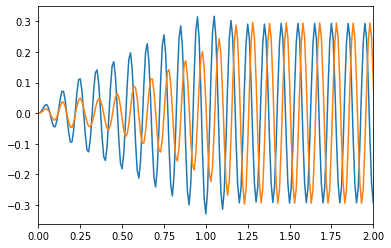

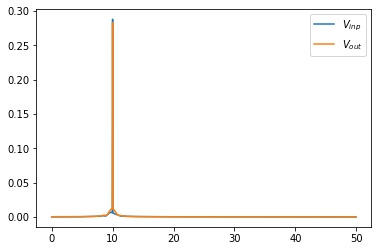

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


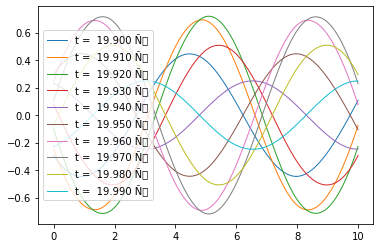

In [13]:
L = (sqrt(Z0**2*f2w(f0)**2*(2*f2w(fh)**2-f2w(fl)**2-f2w(f0)**2)/
    ((f2w(fh)**2-f2w(fl)**2)**2*(f2w(f0)**2-f2w(fl)**2))))
C1 = 1.0 / L / (f2w(fh)**2 - f2w(fl)**2)
C2 = 1.0 / (f2w(fl)**2 * L)
G = 0
print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))

npp = 10            #Количество точек на период гармонического сигнала
dt = 1/(fc*npp)     #Шаг по времени
num = int(Tc / dt)  #Количество временных отсчетов

freq = np.linspace(0.8*fl, fh*1.2, num)

#Задание производной сигнала возбуждения ЛП
d_signal = d_harm_signal2

A0 = 1 #Амплитуда сигнала слева
AN = 0.5 #Амплитуда сигнала справа
K0 = KN = 1 #Коэффициенты при нагрузочных сопротивлениях

#Количество итераций для решения уравнений возбуждения
dpp = 20
print('dpp = {0: d}'.format(dpp))

aU = [0] * Nc     #Массив напряжений на емкости C2
dU = [0] * Nc     #Массив производных напряжений на емкости C2
aV = [0] * (Nc+1) #Массив напряжений на емкости C1
dV = [0] * (Nc+1) #Массив производных напряжений на емкости C1

Vinp = [0] * num  #Массив входных напряжений
Vout = [0] * num  #Массив выходных напряжений
time = [0] * num  #Массив временных отсчетов
Vs = [0] * npp    #Массив напряжений на C1 вдоль ЛП на одном периоде сигнала

for i in range(npp): Vs[i] = [0] * (Nc+1)

#Решение уравнений возбуждения ЛП
for it in range(num):        
    time[it] = dt * it
    for i in range(dpp):
        dV[0] += (1.0/(L*C1)*(aV[1]-aV[0]+aU[0])+1.0/(Z0*K0*C1)*(A0*d_signal(time[it])-dV[0]))*dt/dpp
        for ic in range (Nc):
            dU[ic] += (1.0/(L*C2)*(aV[ic]-aV[ic+1]-aU[ic])-G/C2*dU[ic])*dt/dpp
            if ic == 0: continue
            dV[ic] += (0.5/(L*C1)*(aV[ic-1]-2.0*aV[ic]+aV[ic+1]+aU[ic]-aU[ic-1]))*dt/dpp
        dV[Nc] += (1.0/(L*C1)*(aV[Nc-1]-aV[Nc]-aU[Nc-1])+1.0/(Z0*KN*C1)*(AN*d_signal(time[it])-dV[Nc]))*dt/dpp
        for ic in range(Nc):
            aV[ic] += dV[ic]*dt/dpp
            aU[ic] += dU[ic]*dt/dpp
        aV[Nc] += dV[Nc]*dt/dpp
    if num-it <= npp:
        for ic in range(Nc+1):
            Vs[it-(num-npp)][ic] = aV[ic]
    Vinp[it] = aV[0]
    Vout[it] = aV[Nc]
    if it % 100 == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp[it], Vout[it]))

#Расчет спектра входного и выходного сигалов
spectr_inp = np.fft.fft(Vinp)
spectr_out = np.fft.fft(Vout)
fft_freq = np.fft.fftfreq(num, Tc/num)
plt.axis(xmin=0, xmax=2)
plt.plot(time, Vinp, time, Vout)
plt.show()

sp_inp = np.hypot(spectr_inp.real, spectr_inp.imag)/num*2
sp_out = np.hypot(spectr_out.real, spectr_out.imag)/num*2
plt.plot(fft_freq[0:num//2], sp_inp[0:num//2], label='$V_{inp}$')
plt.plot(fft_freq[0:num//2], sp_out[0:num//2], label='$V_{out}$')
plt.legend(loc='best')
plt.show()

cells = np.linspace(0, Nc, Nc+1)
z_spl = np.linspace(0, Nc, (Nc+1)*10)
for i in range(npp):
    spl = make_interp_spline(cells, Vs[i], k=3)
    plt.plot(z_spl, spl(z_spl), label="t = {0: .3f} Ñ".format(time[num-npp+i]), lw=1)
plt.legend(loc='best')
plt.show()

<h3>Рассчитаем сигнал при AN=0 G=1</h3>

Параметры отдельной ячейки ЛП:
C1 =  0.000153
C2 =  0.001223
L =  0.828269
dpp =  20
  0.000   0.000   0.000 
  1.000  -0.517   0.280 
  2.000  -0.520   0.333 
  3.000  -0.520   0.333 
  4.000  -0.520   0.333 
  5.000  -0.520   0.333 
  6.000  -0.520   0.333 
  7.000  -0.520   0.333 
  8.000  -0.520   0.333 
  9.000  -0.520   0.333 
 10.000  -0.520   0.333 
 11.000  -0.520   0.333 
 12.000  -0.520   0.333 
 13.000  -0.520   0.333 
 14.000  -0.520   0.333 
 15.000  -0.520   0.333 
 16.000  -0.520   0.333 
 17.000  -0.520   0.333 
 18.000  -0.520   0.333 
 19.000  -0.520   0.333 


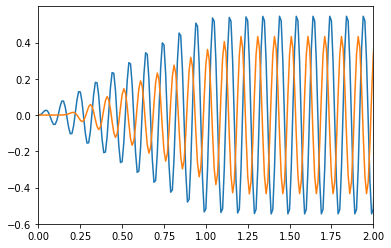

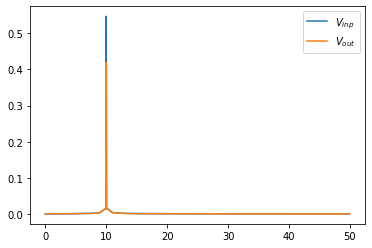

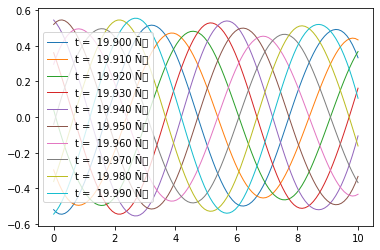

In [14]:
L = (sqrt(Z0**2*f2w(f0)**2*(2*f2w(fh)**2-f2w(fl)**2-f2w(f0)**2)/
    ((f2w(fh)**2-f2w(fl)**2)**2*(f2w(f0)**2-f2w(fl)**2))))
C1 = 1.0 / L / (f2w(fh)**2 - f2w(fl)**2)
C2 = 1.0 / (f2w(fl)**2 * L)
G = 1
print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))

npp = 10            #Количество точек на период гармонического сигнала
dt = 1/(fc*npp)     #Шаг по времени
num = int(Tc / dt)  #Количество временных отсчетов

freq = np.linspace(0.8*fl, fh*1.2, num)

#Задание производной сигнала возбуждения ЛП
d_signal = d_harm_signal2

A0 = 1 #Амплитуда сигнала слева
AN = 0 #Амплитуда сигнала справа
K0 = KN = 1 #Коэффициенты при нагрузочных сопротивлениях

#Количество итераций для решения уравнений возбуждения
dpp = 20
print('dpp = {0: d}'.format(dpp))

aU = [0] * Nc     #Массив напряжений на емкости C2
dU = [0] * Nc     #Массив производных напряжений на емкости C2
aV = [0] * (Nc+1) #Массив напряжений на емкости C1
dV = [0] * (Nc+1) #Массив производных напряжений на емкости C1

Vinp = [0] * num  #Массив входных напряжений
Vout = [0] * num  #Массив выходных напряжений
time = [0] * num  #Массив временных отсчетов
Vs = [0] * npp    #Массив напряжений на C1 вдоль ЛП на одном периоде сигнала

for i in range(npp): Vs[i] = [0] * (Nc+1)

#Решение уравнений возбуждения ЛП
for it in range(num):        
    time[it] = dt * it
    for i in range(dpp):
        dV[0] += (1.0/(L*C1)*(aV[1]-aV[0]+aU[0])+1.0/(Z0*K0*C1)*(A0*d_signal(time[it])-dV[0]))*dt/dpp
        for ic in range (Nc):
            dU[ic] += (1.0/(L*C2)*(aV[ic]-aV[ic+1]-aU[ic])-G/C2*dU[ic])*dt/dpp
            if ic == 0: continue
            dV[ic] += (0.5/(L*C1)*(aV[ic-1]-2.0*aV[ic]+aV[ic+1]+aU[ic]-aU[ic-1]))*dt/dpp
        dV[Nc] += (1.0/(L*C1)*(aV[Nc-1]-aV[Nc]-aU[Nc-1])+1.0/(Z0*KN*C1)*(AN*d_signal(time[it])-dV[Nc]))*dt/dpp
        for ic in range(Nc):
            aV[ic] += dV[ic]*dt/dpp
            aU[ic] += dU[ic]*dt/dpp
        aV[Nc] += dV[Nc]*dt/dpp
    if num-it <= npp:
        for ic in range(Nc+1):
            Vs[it-(num-npp)][ic] = aV[ic]
    Vinp[it] = aV[0]
    Vout[it] = aV[Nc]
    if it % 100 == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp[it], Vout[it]))

#Расчет спектра входного и выходного сигалов
spectr_inp = np.fft.fft(Vinp)
spectr_out = np.fft.fft(Vout)
fft_freq = np.fft.fftfreq(num, Tc/num)
plt.axis(xmin=0, xmax=2)
plt.plot(time, Vinp, time, Vout)
plt.show()

sp_inp = np.hypot(spectr_inp.real, spectr_inp.imag)/num*2
sp_out = np.hypot(spectr_out.real, spectr_out.imag)/num*2
plt.plot(fft_freq[0:num//2], sp_inp[0:num//2], label='$V_{inp}$')
plt.plot(fft_freq[0:num//2], sp_out[0:num//2], label='$V_{out}$')
plt.legend(loc='best')
plt.show()

cells = np.linspace(0, Nc, Nc+1)
z_spl = np.linspace(0, Nc, (Nc+1)*10)
for i in range(npp):
    spl = make_interp_spline(cells, Vs[i], k=3)
    plt.plot(z_spl, spl(z_spl), label="t = {0: .3f} Ñ".format(time[num-npp+i]), lw=1)
plt.legend(loc='best')
plt.show()